In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
plt.style.use('ggplot')
import researchpy as rp
from scipy import stats
%matplotlib inline
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, precision_recall_fscore_support, f1_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss

In [6]:
df = pd.read_csv('data/clean_df')
df.columns

Index(['Unnamed: 0', 'encounter_id', 'patient_nbr', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'change', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'gender_1', 'gender_Unknown/Invalid',
       'max_glu_serum_>300', 'max_glu_serum_None', 'max_glu_serum_Norm',
       'A1Cresult_>8', 'A1Cresult_None', 'A1Cresult_Norm', 'metformin_No',
       'metformin_Steady', 'metformin_Up', 'repaglinide_No',
       'repaglinide_Steady', 'repaglinide_Up', 'nateglinide_No',
       'nateglinide_Steady', 'nateglinide_Up', 'chlorpropamide_No',
       'chlorpropamide_Steady', 'chlorpropamide_Up', 'glimepiride_No',
       'glimepiride_Steady', 'glimepiride_Up', 'acetohexamide_Steady',
       'glipizide_No', 'glipizide_Steady', 'glipizide_Up', 'glyburide_No',
    

### Baseline feature set and Logistic Regression model

In [133]:
# df.drop(['Unnamed: 0', 'encounter_id', 'patient_nbr'], axis=1, inplace=True)
# df.columns
df.rename(columns={'readmitted_<30d_True':'readmit'}, inplace=True)

In [134]:
df.head()

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,diabetesMed_Yes,readmit
0,15,1,1,7,3,59,0,18,0,0,...,1,1,0,0,0,0,0,0,1,0
1,25,1,1,7,2,11,5,13,2,0,...,0,1,0,0,0,0,0,0,1,0
2,35,1,1,7,2,44,1,16,0,0,...,1,1,0,0,0,0,0,0,1,0
3,45,1,1,7,1,51,0,8,0,0,...,0,1,0,0,0,0,0,0,1,0
4,55,1,1,1,3,31,6,16,0,0,...,0,1,0,0,0,0,0,0,1,0


In [135]:
X = np.array(df[['num_medications', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'number_inpatient']].values)
y  = np.array(df['readmit'])

df['readmit'].value_counts()

0    83900
1    10763
Name: readmit, dtype: int64

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=0)
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8835366819838377

In [137]:
print(confusion_matrix(y_test, y_pred))
# '''
# [TN | FP
# ____|___
#     |
#  FN | TP]
# '''

[[16699    33]
 [ 2172    29]]


In [138]:
recall_score(y_test, y_pred)

0.013175829168559746

In [139]:
precision_score(y_test, y_pred)

0.46774193548387094

In [140]:
pd.Series(y_train).value_counts()

0    67168
1     8562
dtype: int64

### SMOTE
Lets try oversampling the minority class via SMOTE to see if we can improve the recall

In [141]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

In [142]:
np.bincount(y_train)

array([67168, 67168])

In [143]:
lr_smote = LogisticRegression()
lr_smote.fit(X_train, y_train)
y_pred_smote = lr_smote.predict(X_test)
accuracy_score(y_test, y_pred_smote)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5977922146516664

In [144]:
confusion_matrix(y_test, y_pred_smote)

array([[10136,  6596],
       [ 1019,  1182]])

In [145]:
recall_score(y_test, y_pred_smote)

0.5370286233530214

In [146]:
precision_score(y_test, y_pred_smote)

0.15196708665466702

In [147]:
f1_score(y_test, y_pred_smote)

0.2368974847179076

In [148]:
roc_auc_score(y_test, y_pred_smote)

0.5714069724462931

### NearMiss

Let's also try undersampling the majority class with NearMiss

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=0)

In [150]:
np.bincount(y_train)

array([67168,  8562])

In [151]:
nr = NearMiss()
X_train, y_train = nr.fit_sample(X_train, y_train)
np.bincount(y_train)

array([8562, 8562])

In [152]:
lr_nr = LogisticRegression()
lr_nr.fit(X_train, y_train)
y_pred_nr = lr_nr.predict(X_test)
accuracy_score(y_test, y_pred_nr)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.4278244335287593

In [153]:
confusion_matrix(y_test, y_pred_nr)
# '''
# [TN | FP
# ____|___
#     |
#  FN | TP]
# '''

array([[ 6549, 10183],
       [  650,  1551]])

In [154]:
recall_score(y_test, y_pred_nr)

0.704679691049523

In [155]:
precision_score(y_test, y_pred_nr)

0.13217998977330833

In [156]:
f1_score(y_test, y_pred_nr)

0.22260495156081808

In [157]:
roc_auc_score(y_test, y_pred_nr)

0.5480426903729565

### ADASYN

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=0)

In [159]:
np.bincount(y_train)

array([67168,  8562])

In [160]:
ad = ADASYN()
X_train, y_train = ad.fit_sample(X_train, y_train)
np.bincount(y_train)

array([67168, 67210])

#### LogisticRegression with ADASYN

In [161]:
lr_ad = LogisticRegression()
lr_ad.fit(X_train, y_train)
y_pred_ad = lr_ad.predict(X_test)
accuracy_score(y_test, y_pred_ad)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5778270744203243

In [162]:
confusion_matrix(y_test, y_pred_ad)
# '''
# [TN | FP
# ____|___
#     |
#  FN | TP]
# '''

array([[9709, 7023],
       [ 970, 1231]])

In [163]:
recall_score(y_test, y_pred_ad)

0.5592912312585189

In [164]:
precision_score(y_test, y_pred_ad)

0.14913981100072693

In [165]:
f1_score(y_test, y_pred_ad)

0.2354854136776662

In [166]:
roc_auc_score(y_test, y_pred_ad)

0.5697782955240718

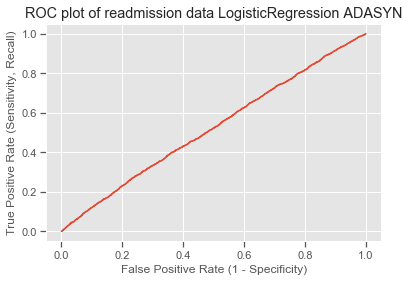

In [170]:
tpr, fpr, thresholds = roc_curve(y_pred_rf, y_test)
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of readmission data LogisticRegression ADASYN")
plt.show()

#### RandomForest with ADASYN

In [167]:
rf =  RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf.score(X_test, y_pred_rf)
roc_auc_score(y_test, y_pred_rf)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5180621993588858

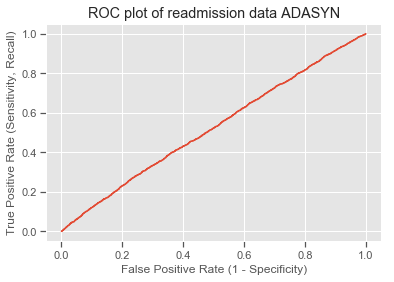

In [169]:
tpr, fpr, thresholds = roc_curve(y_pred_rf, y_test)
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of readmission data ADASYN")
plt.show()

### -----------------------------------------------------------------------

### Improve Feature set

In [171]:
df.columns

Index(['age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'change',
       'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other',
       'gender_1', 'gender_Unknown/Invalid', 'max_glu_serum_>300',
       'max_glu_serum_None', 'max_glu_serum_Norm', 'A1Cresult_>8',
       'A1Cresult_None', 'A1Cresult_Norm', 'metformin_No', 'metformin_Steady',
       'metformin_Up', 'repaglinide_No', 'repaglinide_Steady',
       'repaglinide_Up', 'nateglinide_No', 'nateglinide_Steady',
       'nateglinide_Up', 'chlorpropamide_No', 'chlorpropamide_Steady',
       'chlorpropamide_Up', 'glimepiride_No', 'glimepiride_Steady',
       'glimepiride_Up', 'acetohexamide_Steady', 'glipizide_No',
       'glipizide_Steady', 'glipizide_Up', 'glyburide_No', 'glyburide_Steady',
       'glyburide_Up', 'tolbu

In [175]:
X = np.array(df.drop(['readmit'],axis=1))
y = np.array(df['readmit'])

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

array([[15, 1, 1, ..., 0, 0, 1],
       [25, 1, 1, ..., 0, 0, 1],
       [35, 1, 1, ..., 0, 0, 1],
       ...,
       [75, 1, 1, ..., 0, 0, 1],
       [85, 1, 2, ..., 0, 0, 1],
       [75, 1, 1, ..., 0, 0, 0]], dtype=object)

In [176]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

In [177]:
np.bincount(y_train)

array([67210, 67210])

In [178]:
lr= LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr_nr.predict(X_test)
accuracy_score(y_test, y_pred)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.4278244335287593

In [179]:
roc_auc_score(y_test, y_pred)

0.5480426903729565

In [180]:
f1_score(y_test, y_pred)

0.22260495156081808

In [181]:
recall_score(y_test, y_pred)

0.704679691049523

In [182]:
precision_score(y_test, y_pred)

0.13217998977330833

### RandomForestClassifier

In [184]:
rf = RandomForestClassifier(n_estimators=100, max_features='auto',
                           random_state=0, oob_score=True)
rf.fit(X_train, y_train)
print( rf.oob_score_, rf.score(X_test,y_test))

0.8044413033774735 0.7014207996619659


In [186]:
y_pred_rf = rf.predict(X_test)
roc_auc_score(y_test, y_pred_rf)

0.5219240803220844

In [19]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    prevalence = calc_prevalence(y_actual)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity, prevalence

### SMOTE and StandardScaler

In [188]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)


/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


##### RandomForest

In [191]:
rf1 = RandomForestClassifier(n_estimators=100, max_features='auto', random_state=0, oob_score=True)
rf1.fit(X_train_sc, y_train)
rf1.score(X_train_sc, y_train)
y_pred_rfsc = rf1.predict(X_test_sc)
roc_auc_score(y_test, y_pred_rfsc)


0.5226830452069958

In [210]:
rf_auc, rf_accuracy, rf_recall, rf_precision, \
    rf_specificity, rf_prevalence = print_report(y_test, y_pred_rf, .5)

AUC:0.522
accuracy:0.701
recall:0.288
precision:0.134
specificity:0.756
prevalence:0.116
 


##### KNN

In [195]:
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train_sc, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=100, p=2,
           weights='uniform')

In [203]:
# y_pred_knn = knn.predict(X_test_sc)

knn_auc, knn_accuracy, knn_recall, knn_precision, \
    knn_specificity, knn_prevalence = print_report(y_test, y_pred_knn, .5)


AUC:0.555
accuracy:0.547
recall:0.565
precision:0.140
specificity:0.544
prevalence:0.116
 


##### Logistic Regression

In [205]:
lr = LogisticRegression()
lr.fit(X_train_sc, y_train)
y_pred_lr = lr.predict(X_test_sc)
lr_auc, lr_accuracy, lr_recall, lr_precision, \
    lr_specificity, lr_prevalence = print_report(y_test, y_pred_lr, 0.5)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC:0.576
accuracy:0.547
recall:0.614
precision:0.149
specificity:0.538
prevalence:0.116
 


##### Stochastic Gradient Descent Classifier

In [208]:
sgdc = SGDClassifier(loss='log', alpha=0.1, random_state=0)
sgdc.fit(X_train_sc, y_train)
y_pred_sgdc = sgdc.predict(X_test_sc)

sgdc_auc, sgdc_accuracy, sgdc_recall, sgdc_precision, \
    sgdc_specificity, sgdc_prevalence = print_report(y_test, y_pred_sgdc, 0.5)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


AUC:0.574
accuracy:0.553
recall:0.602
precision:0.149
specificity:0.547
prevalence:0.116
 


##### Gradient Boosting Classifier

In [211]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=0)
gbc.fit(X_train_sc, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [216]:
y_pred_gbc = gbc.predict_proba(X_test_sc)[:,1]

In [217]:
gbc_auc, gbc_accuracy, gbc_recall, gbc_precision, \
    gbc_specificity, gbc_prevalence = print_report(y_test, y_pred_gbc, 0.5)

AUC:0.568
accuracy:0.574
recall:0.520
precision:0.140
specificity:0.581
prevalence:0.116
 


In [221]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='dark')

In [224]:
results = pd.DataFrame({'classifier':['RF', 'KNN', 'LR', 'SGDC', 'GB'],
                       'auc':[rf_auc, knn_auc, lr_auc, sgdc_auc, gbc_auc],
                       'accuracy':[rf_accuracy, knn_accuracy, lr_accuracy, sgdc_accuracy, gbc_accuracy],
                       'recall':[rf_recall, knn_recall, lr_recall, sgdc_recall, gbc_recall],
                       'precision':[rf_precision, knn_precision, lr_precision, sgdc_precision, gbc_precision],
                       'specificity':[rf_specificity, knn_specificity, lr_specificity, sgdc_specificity, gbc_specificity]                        
                       })

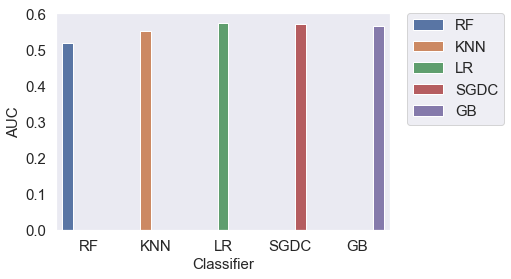

In [225]:
ax = sns.barplot(x="classifier", y="auc", hue="classifier", data=results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

In [34]:
simple_feature_set = ['max_glu_serum_>300', 'max_glu_serum_None', 'max_glu_serum_Norm', 'A1Cresult_>8',
                      'A1Cresult_None', 'A1Cresult_Norm', 'metformin_No', 'metformin_Steady', 
                      'metformin_Up', 'repaglinide_No','repaglinide_Steady', 'repaglinide_Up', 'insulin_No', 
                      'insulin_Steady', 'insulin_Up','change', 'diabetesMed_Yes', 'number_outpatient']


In [35]:
X = np.array(df[simple_feature_set])
y = np.array(df['readmitted_<30d_True'])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [37]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

sc = StandardScaler()
X_train_tf = sc.fit_transform(X_train)
X_test_tf = sc.fit_transform(X_test)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [38]:
lr = LogisticRegression()
lr.fit(X_train_tf, y_train)
y_pred_lr = lr.predict(X_test_tf)
lr_auc, lr_accuracy, lr_recall, lr_precision, \
    lr_specificity, lr_prevalence = print_report(y_test, y_pred_lr, 0.5)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC:0.537
accuracy:0.498
recall:0.589
precision:0.131
specificity:0.486
prevalence:0.116
 


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.12')

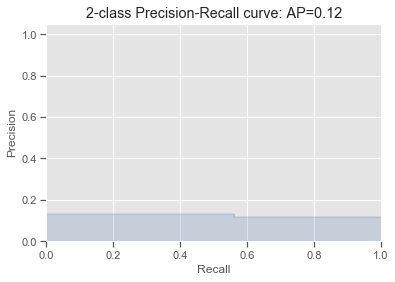

In [33]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from inspect import signature

average_precision = average_precision_score(y_test, y_pred_lr)

precision, recall, _ = precision_recall_curve(y_test, y_pred_lr)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
# fig, ax = plt.subplots(1, figsize=(15,8)
# ax.plot(r, p)
# ax.set_xlim([-.05, 1.05])
# ax.set_ylim([-.05, 1.05])
# ax.set_xlabel('Recall')
# ax.set_ylabel('Precision')
# ax.set_title('PR Curve')   

In [10]:
X = np.array(df[['num_medications', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'number_inpatient']].values)
y = np.array(df['readmitted_<30d'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=0)
logit = sm.Logit(y_train, X_train)
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.385502
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                76521
Model:                          Logit   Df Residuals:                    76516
Method:                           MLE   Df Model:                            4
Date:                Mon, 01 Jul 2019   Pseudo R-squ.:                -0.08855
Time:                        20:27:05   Log-Likelihood:                -29499.
converged:                       True   LL-Null:                       -27099.
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0557      0.002    -33.959      0.000      -0.059      -0.053
x2            -0.0135      0.

In [ ]:
imbalance in classes
which features weredistinguishable between the two classes


### Dummy variables 

Lets test the model with dummy variables. We will remove the diagnosis columns from this as this creates a very large amount of columns. 

In [33]:
X1 = np.array(dummytest.drop(['readmitted_<30d'], axis=1).values)
y1 = np.array(dummytest['readmitted_<30d'].values)

X_traindummy, X_testdummy, y_traindummy, y_testdummy = train_test_split(X1,y1, test_size=0.20, random_state=0)
clf1 = RandomForestClassifier(n_estimators=100,
                              max_features='auto',
                              random_state=0, oob_score=True)
clf1.fit(X_traindummy, y_traindummy)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [34]:
clf1.oob_score_
## 1000 estimators with X1 (dummies) and y1 (dummies) as input

0.8870196751617588

In [35]:
clf1.score(X_testdummy, y_testdummy)

0.8839592246342365

Comparing the two feature sets, the dummy set seemed to perform better. Let's do some further testing by varying the amount of estimators. 

In [36]:
n_estimators = [10,50,100,500]

In [37]:
def random_forest_est(X, y, n_estimators ):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=0)
    result = [['n_estimators', 'oob_score', 'test_score']]
    for n in n_estimators:
        rf = RandomForestClassifier(n_estimators=n, max_features='auto',
                                   random_state=0, oob_score=True)
        rf.fit(X_train, y_train)
        result.append([n, rf.oob_score_, rf.score(X_test,y_test)])
    return result
    

In [39]:
random_forest_est(X1, y1, n_estimators)

/Users/claudiostaub/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/claudiostaub/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/claudiostaub/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[['n_estimators', 'oob_score', 'test_score'],
 [10, 0.8666710682688499, 0.8816352400570433],
 [50, 0.8862934108015318, 0.8838535889716368],
 [100, 0.8870196751617588, 0.8839592246342365],
 [500, 0.8872177472600027, 0.8838535889716368]]

In [48]:
test_size = [0.1, 0.15, 0.2]
def random_forest_test_size(X, y, test_size ):
    result = [['test_size', 'oob_score', 'test_score']]
    for size in test_size:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=0)
        rf = RandomForestClassifier(n_estimators=100, max_features='auto',
                                   random_state=0, oob_score=True)
        rf.fit(X_train, y_train)
        result.append([size, rf.oob_score_, rf.score(X_test,y_test)])
    return result

In [49]:
random_forest_test_size(X1, y1, test_size)

[['test_size', 'oob_score', 'test_score'],
 [0.1, 0.8867082961641392, 0.8844406887081441],
 [0.15, 0.8865814100891093, 0.8848591549295775],
 [0.2, 0.8870196751617588, 0.8839592246342365]]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=0)
rf = RandomForestClassifier(n_estimators=100, max_features='auto',
                                   random_state=0, oob_score=True)
rf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [61]:
y_pred = rf.predict(X_test)

94663

In [71]:
conf = confusion_matrix(y_test, y_pred)
'''
[TN | FP
____|___
    |
 FN | TP]
'''
tn = conf[0,0]
fp = conf[0,1]
fn = conf[1,0]
tp = conf[1,1]
conf

array([[16722,    10],
       [ 2187,    14]])

In [87]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)
print(precision, recall, f1)


0.5833333333333334 0.006360745115856429 0.01258426966292135


In [82]:
precision_score(y_test, y_pred)

0.5833333333333334

In [83]:
recall_score(y_test, y_pred)

0.006360745115856429

In [86]:
f1_score(y_test, y_pred)

0.01258426966292135

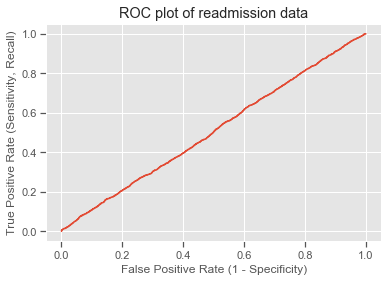

In [73]:
tpr, fpr, thresholds = roc_curve(y_pred, y_test)
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of readmission data")
plt.show()

In [66]:
roc_auc_score(y_test, y_pred)

0.5028815439660086

In [76]:
y_test.sum()

2201

In [90]:
def roc_curve(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df.tpr, df.fpr, prob

### GridSearchCV 

In [92]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt
plt.style.use("ggplot")


In [94]:
df2 = df1

In [101]:
df2.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted_<30d'],
      dtype='object')

In [105]:
lb = LabelBinarizer()
df2['readmitted_<30d'] = lb.fit_transform(df2['readmitted_<30d'].values)
targets = df2['readmitted_<30d']
feat = df2.drop(['encounter_id', 'patient_nbr', 'readmitted_<30d'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(feat, targets, stratify=targets)

In [99]:
df2.drop(['diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True)